In [1]:
import cv2
import os

def create_blurred_images(original_folder, blurred_folder):
    if not os.path.exists(blurred_folder):
        os.makedirs(blurred_folder)

    for img_name in os.listdir(original_folder):
        img_path = os.path.join(original_folder, img_name)
        img = cv2.imread(img_path)
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
        cv2.imwrite(os.path.join(blurred_folder, img_name), blurred_img)

# Đường dẫn đến thư mục chứa ảnh gốc
original_folder = './DenoisingImages/original'
blurred_folder = './DenoisingImages/blurred'

create_blurred_images(original_folder, blurred_folder)


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Conv2DTranspose  # Import Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
import os

# Class để đọc ảnh và trả về batch
class ImageDataGenerator(Sequence):
    def __init__(self, blurred_folder_path, original_folder_path, batch_size=16, img_size=(256, 256)):
        self.blurred_folder_path = blurred_folder_path
        self.original_folder_path = original_folder_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.blurred_images = os.listdir(blurred_folder_path)

    def __len__(self):
        return int(np.ceil(len(self.blurred_images) / self.batch_size))

    def __getitem__(self, index):
        batch_blurred = self.blurred_images[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = []
        Y_batch = []

        for img_name in batch_blurred:
            blurred_path = os.path.join(self.blurred_folder_path, img_name)
            original_path = os.path.join(self.original_folder_path, img_name)

            # Load và xử lý ảnh bị mờ
            img_blurred = load_img(blurred_path, target_size=self.img_size)
            img_blurred = img_to_array(img_blurred) / 255.0
            X_batch.append(img_blurred)

            # Load và xử lý ảnh gốc
            img_original = load_img(original_path, target_size=self.img_size)
            img_original = img_to_array(img_original) / 255.0
            Y_batch.append(img_original)

        return np.array(X_batch, dtype=np.float32), np.array(Y_batch, dtype=np.float32)

def build_model():
    # Load VGG19 pretrained model
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # Freeze all layers in VGG19
    for layer in vgg.layers:
        layer.trainable = False

    # Define input
    input_img = Input(shape=(256, 256, 3))
    
    # Use VGG19 for feature extraction
    x = vgg(input_img)

    # Add layers for upsampling and reconstruction
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)  # Output now (256, 256, 512)
    x = UpSampling2D((2, 2))(x)  # Output now (512, 512, 512)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  
    x = UpSampling2D((2, 2))(x)  # Output now (1024, 1024, 256)

    # Add more upsampling and convolution layers to reach (256, 256, 3)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)  # Output now (1024, 1024, 128)
    x = UpSampling2D((2, 2))(x)  # Output now (2048, 2048, 128)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Output now (2048, 2048, 64)
    x = UpSampling2D((2, 2))(x)  # Output now (4096, 4096, 64)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Output now (4096, 4096, 32)
    x = UpSampling2D((2, 2))(x)  # Output now (8192, 8192, 32)

    # Finally output layer
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Final output should be (256, 256, 3)

    # Define the model
    model = Model(inputs=input_img, outputs=x)

    # Compile the model with the default loss function
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


# Bước 5: Perceptual Loss (Optional)
def perceptual_loss(y_true, y_pred):
    # Sử dụng VGG19 để tính loss perceptual giữa ảnh gốc và ảnh khôi phục
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    loss_model.trainable = False
    return tf.reduce_mean(tf.square(loss_model(y_true) - loss_model(y_pred)))

# Đường dẫn đến thư mục chứa ảnh mờ và ảnh gốc
blurred_folder_path = './DenoisingImages/blurred'
original_folder_path = './DenoisingImages/original'

# Khởi tạo ImageDataGenerator để đọc dữ liệu
train_data_gen = ImageDataGenerator(blurred_folder_path, original_folder_path, batch_size=16)

# Xây dựng mô hình sử dụng mô hình pretrained VGG19
model = build_model()

# Cấu hình EarlyStopping để dừng huấn luyện nếu không có cải thiện
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Huấn luyện mô hình với loss mặc định (Mean Squared Error)
model.fit(train_data_gen, epochs=50, callbacks=[early_stopping])

# Bước 4: Fine-Tuning (Tùy chọn)
# Mở khóa 4 tầng cuối cùng để fine-tune
for layer in model.layers[-4:]:
    layer.trainable = True

# Biên dịch lại mô hình sau khi fine-tune
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện lại mô hình sau khi tinh chỉnh
model.fit(train_data_gen, epochs=10, callbacks=[early_stopping])

# Bước 5: Huấn luyện với Perceptual Loss (Tùy chọn)
# Biên dịch lại mô hình với perceptual loss
model.compile(optimizer='adam', loss=perceptual_loss)

# Huấn luyện lại mô hình với perceptual loss
model.fit(train_data_gen, epochs=50, callbacks=[early_stopping])

# Lưu mô hình sau khi huấn luyện
model.save('image_restoration_model_finetuned_perceptual_loss.h5')


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 106s 22s/step - loss: 0.1407
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 21s/step - loss: 0.1159
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 19s/step - loss: 0.0817
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 20s/step - loss: 0.0812
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 66s 15s/step - loss: 0.0731
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 15s/step - loss: 0.0727
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 24s/step - loss: 0.0710
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 90s 25s/step - loss: 0.0674
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 146s 28s/step - loss: 0.0638
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 79s 19s/step - loss: 0.0656
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 83s 21s/step - loss: 0.0588
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 82s 20s/step - loss: 0.0575
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 78s 20s/step - loss: 0.0593
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 77s 18s/step - loss: 0.0554
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 72s 18s/step - loss: 0.0521
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━

ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.

In [ ]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Đường dẫn đến mô hình đã huấn luyện
model_path = 'image_restoration_model_finetuned_perceptual_loss.h5'
model = load_model(model_path)

# Đường dẫn đến ảnh bị mờ cần phục hồi (chỉ định ảnh cụ thể)
blurred_image_path = './DenoisingImages/blurred/0.jpg'  # Thay 'example_image.jpg' bằng tên ảnh của bạn

# Kích thước ảnh (đảm bảo đúng với kích thước mà mô hình đã được huấn luyện)
img_size = (256, 256)

# Hàm hiển thị ảnh
def display_images(original, restored, img_name):
    plt.figure(figsize=(10, 5))

    # Ảnh bị mờ trước khi phục hồi
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title(f'Blurred Image - {img_name}')
    plt.axis('off')

    # Ảnh sau khi phục hồi
    plt.subplot(1, 2, 2)
    plt.imshow(restored)
    plt.title(f'Restored Image - {img_name}')
    plt.axis('off')

    plt.show()

# Tải và tiền xử lý ảnh bị mờ
img_blurred = load_img(blurred_image_path, target_size=img_size)
img_blurred_array = img_to_array(img_blurred) / 255.0
img_blurred_input = np.expand_dims(img_blurred_array, axis=0)  # Thêm trục batch (1, 256, 256, 3)

# Dự đoán ảnh phục hồi từ mô hình
restored_img = model.predict(img_blurred_input)

# Chuyển đổi lại định dạng ảnh phục hồi
restored_img = np.squeeze(restored_img, axis=0)  # Loại bỏ trục batch
restored_img = np.clip(restored_img, 0, 1)  # Đảm bảo giá trị trong khoảng [0, 1]

# Hiển thị ảnh bị mờ và ảnh phục hồi
img_name = os.path.basename(blurred_image_path)
display_images(img_blurred_array, restored_img, img_name)

print("Testing completed!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


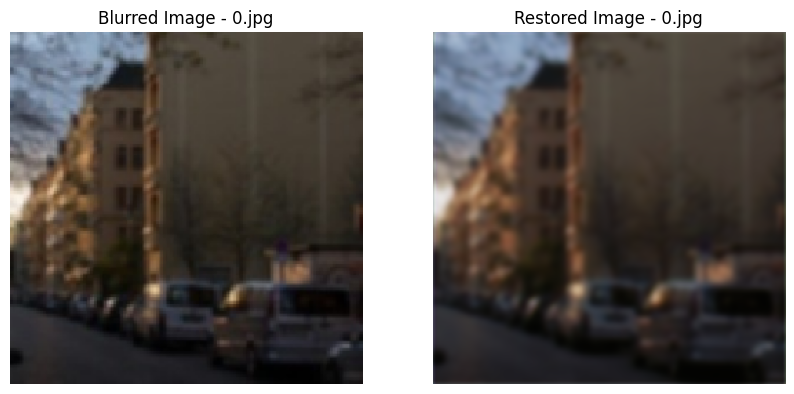

Testing completed!


In [6]:
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Đường dẫn đến mô hình đã huấn luyện
model_path = 'image_restoration_model.h5'
model = load_model(model_path)

# Đường dẫn đến ảnh bị mờ cần phục hồi (chỉ định ảnh cụ thể)
blurred_image_path = './DenoisingImages/blurred/0.jpg'  # Thay 'example_image.jpg' bằng tên ảnh của bạn

# Kích thước ảnh (đảm bảo đúng với kích thước mà mô hình đã được huấn luyện)
img_size = (256, 256)

# Hàm hiển thị ảnh
def display_images(original, restored, img_name):
    plt.figure(figsize=(10, 5))

    # Ảnh bị mờ trước khi phục hồi
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title(f'Blurred Image - {img_name}')
    plt.axis('off')

    # Ảnh sau khi phục hồi
    plt.subplot(1, 2, 2)
    plt.imshow(restored)
    plt.title(f'Restored Image - {img_name}')
    plt.axis('off')

    plt.show()

# Tải và tiền xử lý ảnh bị mờ
img_blurred = load_img(blurred_image_path, target_size=img_size)
img_blurred_array = img_to_array(img_blurred) / 255.0
img_blurred_input = np.expand_dims(img_blurred_array, axis=0)  # Thêm trục batch (1, 256, 256, 3)

# Dự đoán ảnh phục hồi từ mô hình
restored_img = model.predict(img_blurred_input)

# Chuyển đổi lại định dạng ảnh phục hồi
restored_img = np.squeeze(restored_img, axis=0)  # Loại bỏ trục batch
restored_img = np.clip(restored_img, 0, 1)  # Đảm bảo giá trị trong khoảng [0, 1]

# Hiển thị ảnh bị mờ và ảnh phục hồi
img_name = os.path.basename(blurred_image_path)
display_images(img_blurred_array, restored_img, img_name)

print("Testing completed!")
